<a href="https://colab.research.google.com/github/abdelhadidjafer02-beep/GPT-2/blob/main/One_Layer_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####NB: Only the first 0 Layer cell is generated by AI, the rest of the code is written by hand



In [1]:
# @title Setup and Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a random seed for reproducibility
torch.manual_seed(42)

def plot_matrix(matrix, title="Matrix", xlabel="Column", ylabel="Row"):
    """Helper to visualize matrices (Heatmaps)"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix.detach().numpy(), cmap="RdBu", center=0)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

print("Setup complete. Ready for exercises!")

Setup complete. Ready for exercises!


Shape of W_E: torch.Size([10, 64])
Shape of W_U: torch.Size([64, 10])
Shape of Bigram Matrix (W_E @ W_U): torch.Size([10, 10])


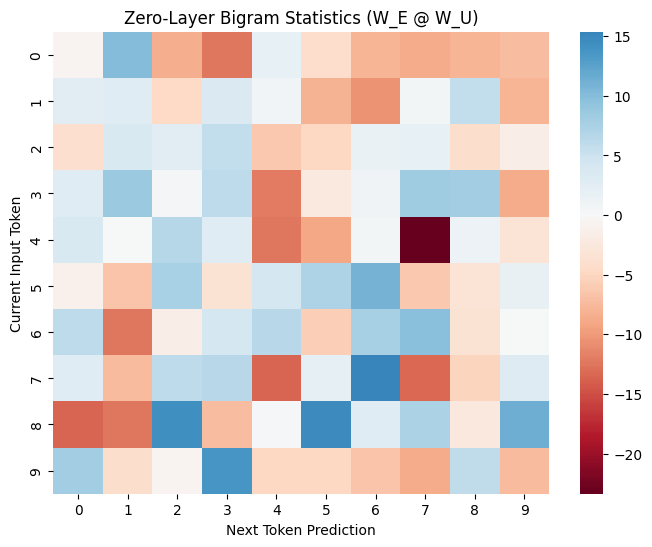


If input is token 3, the model predicts:
Token 0: 0.0013
Token 1: 0.4318
Token 2: 0.0001
Token 3: 0.0332
Token 4: 0.0000
Token 5: 0.0000
Token 6: 0.0002
Token 7: 0.2898
Token 8: 0.2436
Token 9: 0.0000


In [2]:
# @title Exercise 1: The Zero-Layer Transformer
# Dimensions
d_vocab = 10   # Small vocabulary size for readability
d_model = 64   # Size of the residual stream

# 1. Initialize Embedding (W_E) and Unembedding (W_U) matrices
# Random initialization simulates a model that has learned some weights
W_E = torch.randn(d_vocab, d_model) # Shape: [d_vocab, d_model]
W_U = torch.randn(d_model, d_vocab) # Shape: [d_model, d_vocab]

# 2. Compute the "Bigram Matrix"
# This matrix represents the direct path from the input token to the output logits.
# If we input token 'i', the row 'i' of this matrix tells us the logits for the next token.
W_bigram = W_E @ W_U # Shape: [d_vocab, d_vocab]

# 3. Visualization
print(f"Shape of W_E: {W_E.shape}")
print(f"Shape of W_U: {W_U.shape}")
print(f"Shape of Bigram Matrix (W_E @ W_U): {W_bigram.shape}")

plot_matrix(W_bigram, title="Zero-Layer Bigram Statistics (W_E @ W_U)",
            xlabel="Next Token Prediction", ylabel="Current Input Token")

# --- EXPERIMENT ---
# Pick an input token (e.g., index 3) and see what the model predicts next
input_token_idx = 3
logits_for_next = W_bigram[input_token_idx]
probs = F.softmax(logits_for_next, dim=0)

print(f"\nIf input is token {input_token_idx}, the model predicts:")
for i, p in enumerate(probs):
    print(f"Token {i}: {p.item():.4f}")

**Hidden Gem / Intuition:**

In a Zero-Layer model, the "Residual Stream" is just the embedding of the current token. Since there is no attention to "look back," the model can only learn relationships like "Obama" follows "Barack". It cannot solve tasks requiring context (like "The dog... eats" vs "The dogs... eat").

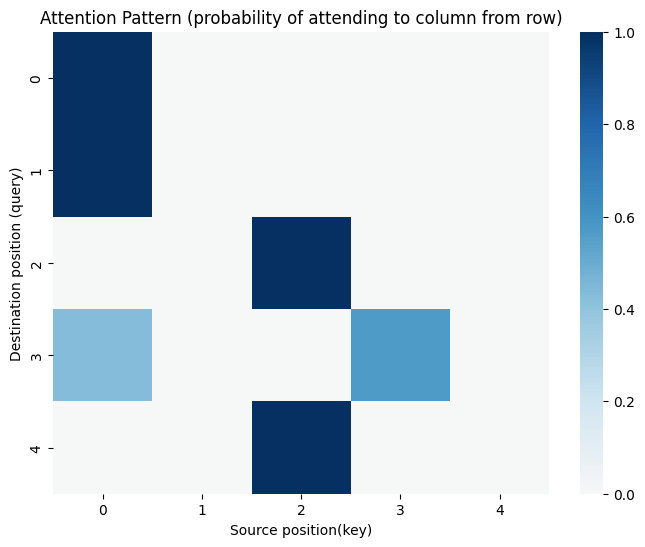

torch.Size([5, 64])

In [3]:
# @title Excercice 2: Implementing a single Attention Head
#  Attenton heads are information movers, they read from source token and write
# to destination token (the current position)
# Dimensions
seq_len=5
d_head=8
# Create random input sequence (residual stream)
# shape: [seq_len, d_model]
x=torch.randn(seq_len, d_model)
# Define the Head's weights
W_Q = torch.randn(d_model, d_head)
W_K = torch.randn(d_model, d_head)
W_V = torch.randn(d_model, d_head)
W_O = torch.randn(d_head, d_model)

# Step 1 : calculate Q, K V
# These are linear projections of the residual stream
Q = x @ W_Q  # [seq_len, d_head]
K = x @ W_K  # [seq_len, d_head]
V = x @ W_V  # [seq_len, d_head]

# Step 2 : Calculate Attention Scores
# Q @ K.T gives us the raw compatibility scres between every pair of tokens
attention_scores = Q @ K.T  # [seq_len, seq_len]
# Scale by sqrt(d_head) (standard practice)
attention_scores = attention_scores / (d_head**0.5)

# Masking (Autoregressive): tokens can't see the future
mask=torch.triu(torch.ones(seq_len, seq_len), diagonal=1)*-1e9
attention_scores=attention_scores+mask

# Softmax to get probabilities
attention_pattern = F.softmax(attention_scores, dim=-1)

plot_matrix(matrix=attention_pattern,
            title="Attention Pattern (probability of attending to column from row)",
            xlabel="Source position(key)", ylabel="Destination position (query)")

# Step 3: Move information (the Z vector):
# Weight the values by the attention pattern
Z= attention_pattern @ V  # [seq_len, d_head]

# Step 4: Output to Residual Stream
# Project back up to d_model
result = Z @ W_O  # [seq_len, d_model]
result.shape

**Hidden Gem / Intuition:**

Notice result. In the Residual Network, this result is added to the original x. This validates the paper's claim: "Attention heads are independent and additive." If you had 12 heads, you would just calculate 12 result vectors and sum them all onto x. They don't touch each other inside the layer!

In [4]:
# @title Exercice 3: The QK Circuit
# the QK Circuit Determines *which* tokens are attended to.
# It effectively creates a bilinear from x_i^T W_{QK} x_j

# Compute the effective QK matrix for the head
# W_Q: [d_model, d_head] , W_K: [d_model, d_head]
# W_QK = W_Q @ W_K.T -> Shape: [d_model, d_model]
W_QK = W_Q @ W_K.T

# Let's verify that x @ W_QK @ x.T gives us the same unscaled attention scores
# (Ignoring the batch/sequence dimension for a simplified vector check)
token_A = x[0]  # The token at position 0 (Destination/Query)
token_B = x[1]  # The token at position 1 (Source/key)

#Method 1: Standard
q_A=token_A @ W_Q
k_B=token_B @ W_K
qk_AB=q_A @ k_B
print(f"Method 1: {qk_AB}")

#Method 2: QK Circuit
#the score is a measure of how much W_QK "likes" the pair (token_A,token_B)
qk_AB=token_A @ W_QK @ token_B
print(f"Method 2: {qk_AB}")

Method 1: 79.97543334960938
Method 2: 79.97540283203125


**Hidden Gem / Intuition:**

The $W_{QK}$ matrix is a lower-rank matrix (rank d_head) living in the larger d_model space. It defines the "rules of attraction" for this specific head. For example, if this head looks for the previous token, $W_{QK}$ acts as a "previous token detector" on the positional embeddings within the residual stream.

$W_{QK}$ is a large (d_model x d_model), but low rank (rank< d_head)
it encodes what pattern this head pays attention to, acts like a Detector or a Filter for certain relationship, can detect: previous tokens, duplicatesn names syntax, matching ...etc

W_OV.shape: torch.Size([64, 64])
Skip-Trigram Matrix Shape: torch.Size([10, 10]) [d_vocab, d_vocab]


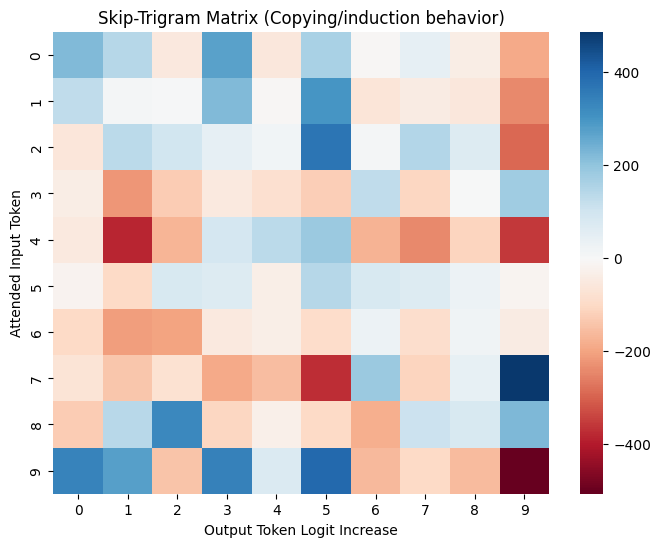

In [5]:
# @title Excercice 4: The OV Circuit
# The OV Circuit describes how a token affects the output *if* it is attended to.

# W_V: [d_model, d_head], W_O: [d_head, d_model]
# W_OV = W_V @ W_O -> Shape: [d_model, d_model]
W_OV = W_V @ W_O
print(f"W_OV.shape: {W_OV.shape}")

# Let's see the full "Virtual Weight" path.
# If a token B is attended to by token A, the effects on the logits is:
# Effect = Embedding(B) @ W_OV @ W_U
# This is a "Virtual Weight" matrix connecting input vocabulary to output
# vocabulary mediated by this specific attention head

# Recall W_E from Exercice 1
# We can compute the "Skip-Trigram" matrix for this head.
#This matrix tells us : "If i attend to token X, which token Y becomes more likely ?"
W_skip_trigram = W_E @ W_OV @ W_U
print(f"Skip-Trigram Matrix Shape: {W_skip_trigram.shape} [d_vocab, d_vocab]")

plot_matrix(W_skip_trigram, title="Skip-Trigram Matrix (Copying/induction behavior)",
            xlabel="Output Token Logit Increase", ylabel="Attended Input Token")


**Hidden Gem / Intuition:**

This is one of the deepest insights in the paper. Even though the Transformer is deep, a single head in a one-layer model can be fully described as a big matrix ($W_{skip\_trigram}$) that says: "If I see word 'cat' in the past, increase probability of 'meow' now."
The paper calls these "Eigen-values of the OV circuit"—if the matrix has positive values on the diagonal, it's a Copying Head (attending to "X" makes "X" more likely).

In [6]:
# @title Exercise 5: Verification of Additivity
# We will show that the final logits are just the sum of the Bigram Term and the Head Terms.

# 1. Bigram Term (from Exercise 1)
# Direct path: Input -> W_E -> W_U
term_bigram = x @ W_U # [seq_len, d_vocab]

# 2. Attention Term (from Exercise 2)
# Indirect path: Input -> Attention -> W_OV -> W_U
# We take the 'result' from Ex 2 (which is post-W_O) and project to logits
term_attention = result @ W_U # [seq_len, d_vocab]

# 3. Total Logits
total_logits = term_bigram + term_attention

print("Logits decomposed successfully.")
print(f"Bigram contribution range: {term_bigram.min():.2f} to {term_bigram.max():.2f}")
print(f"Attention contribution range: {term_attention.min():.2f} to {term_attention.max():.2f}")

# Intuition check:
# The Bigram term handles static probability (e.g., "The" is common).
# The Attention term handles context (e.g., "The" -> "cat" because "meow" was seen previously).

Logits decomposed successfully.
Bigram contribution range: -18.60 to 17.37
Attention contribution range: -394.60 to 232.08
